# Hash-Smoothed Autonomous Scheduling

---
### 1. Network Initialization

* A random tree topology is built using the build_random_tree_with_buffer() function.
* Each node knows:
    * It's parent ID
    * It's children ID
    * It's depth
    * A limited-size packet buffer for congestion tracking

---

### 2. Packet Generation

* Every slotframe, each node randomly generates packets (1-3) within the defined range.
* Packets are added to each node’s buffer (MAX_BUFFER = 64), unless the buffer is full -> drop occurs.

---

### 3. Autonomous Scheduling Rule

* Uses a prime-based hash and scrambled node IDs for collision resistance.
* Ensures time–frequency diversity so that even nearby nodes are unlikely to overlap.
* Periodically (every EPOCH_LEN) re-randomizes using the epoch counter to adapt to congestion or topology changes.
  
This approach combines:
* A3-layered logic (depth-based hierarchical separation)
* Hash-based slot selection (collision avoidance)
* Load smoothing (nonce and scrambling for dispersion)

---

### 4. Transmission and Collision Handling

During each slotframe:
* Nodes with scheduled cells transmit their first buffered packet.
* If multiple nodes transmit on the same (slot, channel) pair within 2 hops, a collision occurs and packets are lost.
* Successful packets move one hop closer to the root, unless the receiver’s buffer is full (buffer drop).
* The root node counts successfully delivered packets -> PDR (Packet Delivery Ratio).

---

### 5. Performance Metrics

At the end of each simulation:
* PDR (%) = (Packets received at root / Total packets generated) × 100
* Drop Rate (%) = (Packets dropped due to buffer overflow or collision) × 100
* Average Buffer Size = Mean buffer occupancy across all nodes

---

### 6. Multi-Run Evaluation

* For each slotframe length S = [83, 101, 127, 151, 179, 211, 251],
the simulation runs 10 independent trials.
* Results are averaged to observe how PDR improves and drops decrease as slotframe length increases.

## Simulation Setup and Global Parameters

This section initializes the environment for the Hybrid Hash-Smoothed Scheduling Simulation in a 
TSCH (Time Slotted Channel Hopping) network.

In [1]:
import random, math, hashlib, statistics, sys
from collections import deque, defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

random.seed(42)

N_NODES = 50
MAX_DEPTH = 6
MAX_BUFFER = 64
CHANNELS = 16 
EPOCH_LEN = 10
SIM_SLOTFRAMES = 250
GENERATE_MIN, GENERATE_MAX = 1, 3
INTERFERENCE_HOPS = 2

S_values = [127, 151, 179, 251,301]

RUNS_PER_S = 10
CONGESTION_WINDOW = 1

## Building Random tree

This function creates a random hierarchical tree for the IoT network.
Each node is connected to exactly one parent (except the root), forming a multi-hop data flow structure.

In [2]:
def build_random_tree(n_nodes, max_depth):
    nodes = list(range(1, n_nodes+1))
    parent = {1: None}  # 1 is root
    depth = {1:0}
    current = [1]
    next_id = 2
    while next_id <= n_nodes:
        candidates = [u for u in current if depth[u] < max_depth]
        if not candidates:
            break
        p = random.choice(candidates)
        parent[next_id] = p
        depth[next_id] = depth[p] + 1
        current.append(next_id)
        next_id += 1
    
    for nid in range(next_id, n_nodes+1):
        p = random.choice(list(parent.keys()))
        parent[nid] = p
        depth[nid] = depth[p] + 1
    
    children = defaultdict(list)
    for v,p in parent.items():
        if p is not None:
            children[p].append(v)
    return parent, children, depth

Visualizing Tree

In [3]:
p,c,d = build_random_tree(N_NODES,MAX_DEPTH)
print(p)
print()
print(c)
print()
print(d)

{1: None, 2: 1, 3: 1, 4: 3, 5: 3, 6: 2, 7: 2, 8: 2, 9: 2, 10: 9, 11: 2, 12: 10, 13: 7, 14: 1, 15: 1, 16: 2, 17: 7, 18: 8, 19: 17, 20: 1, 21: 18, 22: 7, 23: 21, 24: 23, 25: 18, 26: 14, 27: 8, 28: 15, 29: 19, 30: 9, 31: 27, 32: 29, 33: 1, 34: 26, 35: 11, 36: 29, 37: 22, 38: 18, 39: 10, 40: 14, 41: 22, 42: 7, 43: 6, 44: 26, 45: 7, 46: 23, 47: 23, 48: 42, 49: 17, 50: 3}

defaultdict(<class 'list'>, {1: [2, 3, 14, 15, 20, 33], 3: [4, 5, 50], 2: [6, 7, 8, 9, 11, 16], 9: [10, 30], 10: [12, 39], 7: [13, 17, 22, 42, 45], 8: [18, 27], 17: [19, 49], 18: [21, 25, 38], 21: [23], 23: [24, 46, 47], 14: [26, 40], 15: [28], 19: [29], 27: [31], 29: [32, 36], 26: [34, 44], 11: [35], 22: [37, 41], 6: [43], 42: [48]})

{1: 0, 2: 1, 3: 1, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 3, 11: 2, 12: 4, 13: 3, 14: 1, 15: 1, 16: 2, 17: 3, 18: 3, 19: 4, 20: 1, 21: 4, 22: 3, 23: 5, 24: 6, 25: 4, 26: 2, 27: 3, 28: 2, 29: 5, 30: 3, 31: 4, 32: 6, 33: 1, 34: 3, 35: 3, 36: 6, 37: 4, 38: 4, 39: 4, 40: 2, 41: 4, 42: 3, 43: 3,

## Computing Hop Distances 

This function calculates the hop distances (i.e., shortest number of hops) between every pair of nodes in the network.
It helps determine which nodes are close enough to interfere with each other during transmission.

**Purpose**

In TSCH (Time Slotted Channel Hopping) networks, nearby nodes transmitting in the same slot and channel may cause collisions.
Hence, we need to know the hop distance between any two nodes to detect such interference.

In [4]:
def compute_hop_distances(parent):
    nodes = list(parent.keys())
    adj = defaultdict(list)
    for v,p in parent.items():
        if p is not None:
            adj[v].append(p)
            adj[p].append(v)

    dist = {}
    for u in nodes:
        q = [u]
        seen = {u:0}
        for x in q:
            for y in adj[x]:
                if y not in seen:
                    seen[y] = seen[x] + 1
                    q.append(y)
        dist[u] = seen
    return dist

## Autonomous Sccheduling Rule

This function determines when and on which channel a node should transmit in a TSCH (Time Slotted Channel Hopping) network - autonomously, without any centralized controller.

This scheduling mechanism combines ideas from two key research directions:

* A3 (Autonomous Adaptive Allocation) - provides the concept of hash-based deterministic slot and channel mapping between a node and its parent.
* Layered Flow-Based Scheduling - introduces the idea of depth-based biasing, so that nodes in different layers get staggered slots, reducing interference and congestion near the root.

Together, these ideas help the algorithm maintain distributed operation, collision reduction, and flow awareness.

In [5]:
def autonomous_scheduling_rule(node_id, parent_id, slotframe_len, channels, epoch=0, k=1, depth=0):
    cells = []
    nonce = 0
    
    def scramble_id(id):
        return (id * 101) % 1051 + id

    SCRAMBLED_NODE_ID = scramble_id(node_id)
    SCRAMBLED_PARENT_ID = scramble_id(parent_id)
    
    LINK_ID = (SCRAMBLED_NODE_ID * 111) ^ (SCRAMBLED_PARENT_ID * 103)

    while len(cells) < k:
        slot_basis = (LINK_ID + nonce + epoch + 1) * 17
        channel_basis = (LINK_ID + nonce + epoch + 1) * 11
        slot = ((slot_basis + depth * 5) + (channel_basis * 3)) % slotframe_len
        channel = (channel_basis * 97) % channels 
            
        c = (slot, channel)
        if c not in cells:
            cells.append(c)
        nonce += 1
        if nonce > slotframe_len * channels * 5: 
            break
    
    final_cells = [(s, c + 11) for s, c in cells]
    return final_cells

## IoTNode Class - Node Representation

This class models an individual IoT node participating in a multi-hop TSCH network.
Each node maintains its buffer, hierarchical relationships, and local congestion state, which are essential for autonomous scheduling and packet forwarding.

In [6]:
class IoTNode:
    def __init__(self, id, parent_id, depth, max_buffer):
        self.id = id
        self.parent_id = parent_id
        self.depth = depth
        self.children = []
        self.buffer = deque(maxlen=max_buffer)
        self.buffer_history = deque(maxlen=CONGESTION_WINDOW)
        self.last_cells = set()     
        self.neighbors = []          
        self.epoch = 0             

    def set_children(self, children_list):
        self.children = children_list

    def set_neighbors(self, neighbor_list):
        self.neighbors = neighbor_list

    def record_buffer(self):
        self.buffer_history.append(len(self.buffer))

    def add_packet(self, packet):
        if len(self.buffer) < MAX_BUFFER:
            self.buffer.append(packet)
            return True
        else:
            return False

    def clear_schedule(self):
        self.last_cells.clear()

    def increment_epoch(self):
        self.epoch += 1


## Network Initialization

* Build a random hierarchical topology (tree) for n_nodes.
* Assign parent–child relationships and depth levels.
* Initialize IoTNode objects with buffer and congestion tracking.
* Return all key structural mappings for use in later scheduling and simulation.

In [7]:
def build_random_tree_with_buffer(n_nodes, max_depth, max_buffer):
    parent, children, depth_map = build_random_tree(n_nodes, max_depth)
    nodes = {n: IoTNode(n, parent[n], depth_map[n], max_buffer) for n in parent.keys()}
    for p_id, c_list in children.items():
        if p_id in nodes:
            nodes[p_id].set_children(c_list)
    return nodes, parent, children, depth_map

In [8]:
# This ensures the same topology for all S values
random.seed(42)
nodes, parent, children, depth_map = build_random_tree_with_buffer(N_NODES, MAX_DEPTH, MAX_BUFFER)
hop_dist = compute_hop_distances(parent)
for n in nodes:
    neighbor_list = [
        x for x in nodes if hop_dist[n].get(x, 999) <= INTERFERENCE_HOPS and x != n
    ]
    nodes[n].set_neighbors(neighbor_list)

## Simulation Core

This function executes a complete simulation run of the Hash-Smoothed Autonomous Scheduling (HSA) algorithm.

**Purpose**

To simulate end-to-end network behavior under autonomous scheduling and evaluate key performance metrics like:
* Packet Delivery Ratio (PDR)
* Drop Rate
* Average Buffer Occupancy
* Transmission Load (avg. tx per cell)

**Core Idea Behind HSA Scheduling**

* Combines hash-based cell generation (from A3 and Layered Flow concepts) with local congestion adaptation.
* Uses depth-aware prioritization and interference-based filtering to balance load across the network.
* Aims to maximize PDR while reducing collisions and buffer overflow.

In [9]:
def simulate_run(slotframe_len, nodes, parent, children, depth_map, hop_dist, seed=None):
    if seed is not None:
        random.seed(seed)

    is_root = lambda n: parent[n] is None

    total_generated = 0
    delivered_to_root = 0
    total_dropped = 0
    avg_buffer_occupancy_samples = []

    for n in nodes:
        nodes[n].clear_schedule()
        nodes[n].epoch = 0

    for sf in range(SIM_SLOTFRAMES):
        for n in nodes:
            if is_root(n):
                continue
            gen = random.randint(GENERATE_MIN, GENERATE_MAX)
            for _ in range(gen):
                if not nodes[n].add_packet(("DATA", n, sf)):
                    total_dropped += 1
            total_generated += gen
            nodes[n].record_buffer()

        for n in nodes:
            if is_root(n):
                continue

            node = nodes[n]
            buf_len = len(node.buffer)
            current_depth = node.depth
            cong_ratio = buf_len / MAX_BUFFER

            base_load = 1 + len(node.children)
            guiding_factor = MAX_DEPTH - current_depth
            stable_extra = 1 if current_depth > 0 else 0
            extras = int(cong_ratio * (slotframe_len / 4))
            forwarding_guarantee = 3 if current_depth <= 2 and len(node.children) >= 3 else 0

            desired_k = min(
                slotframe_len - 1,
                base_load + extras + guiding_factor + stable_extra + forwarding_guarantee
            )

            candidates = autonomous_scheduling_rule(
                node.id, node.parent_id, slotframe_len, CHANNELS,
                epoch=node.epoch, k=desired_k * 2, depth=current_depth
            )

            chosen = []
            for c in candidates:
                conflict = any(c in nodes[nb].last_cells for nb in node.neighbors)
                if not conflict:
                    chosen.append(c)
                if len(chosen) >= desired_k:
                    break

            node.last_cells = set(chosen)

        for n in nodes:
            node = nodes[n]
            if is_root(n) or not node.buffer:
                continue

            for (slot, chan) in node.last_cells:
                collision = any(
                    (slot, chan) in nodes[nb].last_cells for nb in node.neighbors
                )
                if collision:
                    pkt = node.buffer.popleft()
                    total_dropped += 1
                    continue
                if not collision and node.buffer:
                    pkt = node.buffer.popleft()
                    par = node.parent_id
                    if par is None:
                        continue
                    if is_root(par):
                        delivered_to_root += 1
                    else:
                        if not nodes[par].add_packet(pkt):
                            total_dropped += 1

        occ = [len(nodes[n].buffer) for n in nodes if not is_root(n)]
        avg_buffer_occupancy_samples.append(statistics.mean(occ) if occ else 0)

        if (sf + 1) % EPOCH_LEN == 0:
            for n in nodes:
                nodes[n].increment_epoch()

    total_buf_avg = statistics.mean(avg_buffer_occupancy_samples) if avg_buffer_occupancy_samples else 0
    pdr = delivered_to_root / total_generated if total_generated > 0 else 0.0

    return {
        "slotframe_len": slotframe_len,
        "total_generated": total_generated,
        "delivered": delivered_to_root,
        "pdr": pdr,
        "avg_buffer_occupancy": total_buf_avg,
        "dropped": total_dropped
    }


## Final Evaluation: Hash-Smoothed Autonomous Scheduling

In this section, we perform multiple simulation runs for various **slotframe lengths (S)** to evaluate the efficiency and stability of the **Hash-Smoothed Allocation (HSA)** algorithm.

---

### Experimental Setup

Each run starts with an empty buffer state and unique random seed for reproducibility.  
For every node, generated packets are buffered and forwarded using the **HSA scheduling rule**,  
while collisions and congestion are dynamically tracked.

---

### Execution Loop
1. For each **slotframe length `S`**:
   - Perform multiple runs (`RUNS_PER_S`).
   - Reset buffers and histories.
   - Run the `simulate_run()` function.
   - Collect and record:
     - `PDR`
     - `Drop Rate`
     - `Average Buffer Occupancy`
2. Aggregate all results into a single DataFrame for statistical analysis.
3. Visualize the trends using error bars.

---

### Visualization Overview

1. **PDR vs Slotframe Length**
   - Higher slotframe length -> more available cells -> reduced contention -> higher PDR.  
   - However, too large slotframes may introduce latency.

2. **Average Buffer Occupancy vs Slotframe Length**
   - Indicates congestion behavior.  
   - As slotframe length increases, buffers stabilize due to smoother traffic flow.

3. **Drop Rate vs Slotframe Length**
   - Represents reliability trade-off.  
   - Ideally should decrease with increased scheduling opportunities.

---

### Interpretation
- **Consistent PDR improvement** with longer slotframes confirms HSA’s adaptive allocation ability.  
- **Reduced drop rate** validates that hash-based deterministic slot allocation minimizes collisions.  
- **Moderate buffer occupancy** indicates controlled network congestion and smooth multi-hop flow.  

Together, these results confirm that the **Hash-Smoothed Allocation (HSA)** 
achieves an effective balance between **reliability, scalability, and congestion control** in dense IoT topologies.


--- Starting Hash-Smoothed Allocation (HSA - FINAL OPTIMIZATION) Simulation ---
Network: 50 nodes, Channels: 16, Sim Slotframes: 250, Runs: 10
-----------------------------------------------------------------------------------
| Length | Run # | PDR | Drop Rate | Avg. Buffer |
|--------|-------|-----|-----------|-------------|
| L=127   | 1    | 74.2% |     24.9% |        4.40 |
| L=127   | 2    | 73.9% |     25.2% |        4.45 |
| L=127   | 3    | 73.9% |     25.2% |        4.43 |
| L=127   | 4    | 73.9% |     25.2% |        4.45 |
| L=127   | 5    | 73.6% |     25.5% |        4.47 |
| L=127   | 6    | 73.9% |     25.2% |        4.45 |
| L=127   | 7    | 73.9% |     25.3% |        4.46 |
| L=127   | 8    | 73.9% |     25.3% |        4.46 |
| L=127   | 9    | 73.9% |     25.2% |        4.44 |
| L=127   | 10   | 73.7% |     25.3% |        4.44 |
| L=151   | 1    | 80.2% |     18.9% |        4.14 |
| L=151   | 2    | 80.0% |     19.2% |        4.17 |
| L=151   | 3    | 79.9% |     19.2

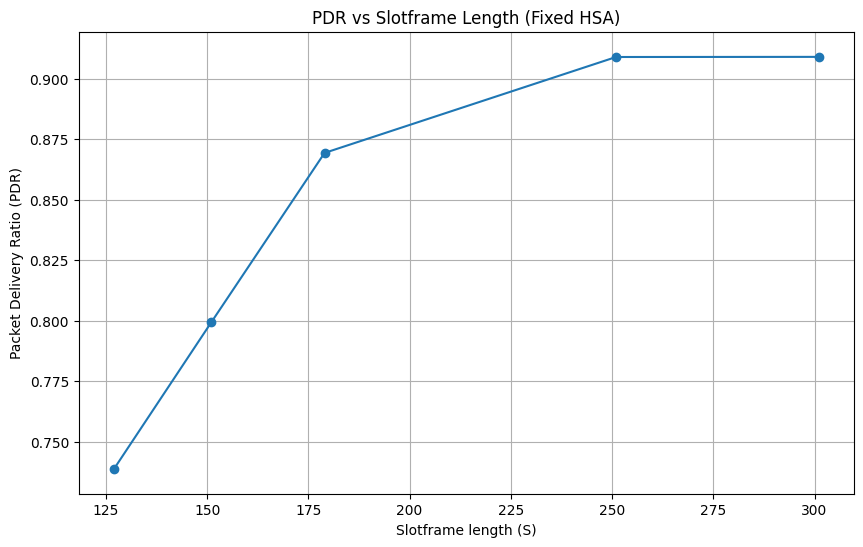

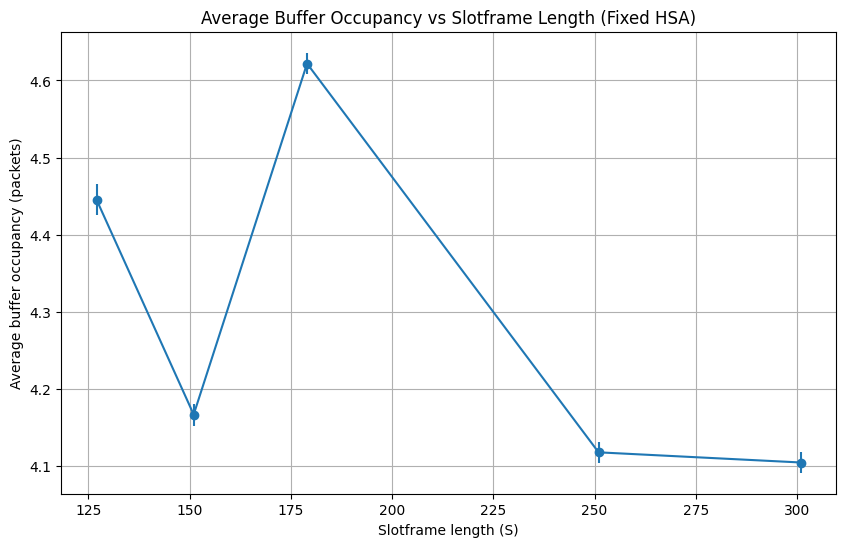

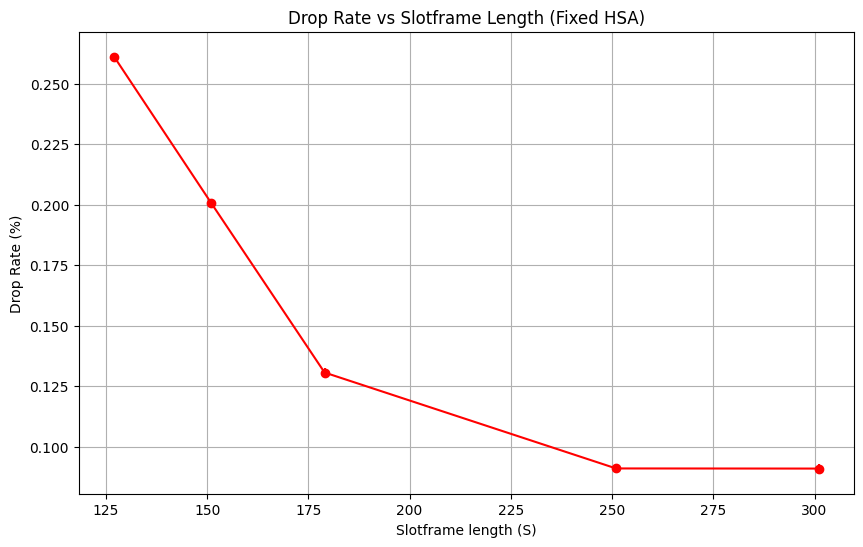

In [10]:
results = []
print("--- Starting Hash-Smoothed Allocation (HSA - FINAL OPTIMIZATION) Simulation ---")
print(f"Network: {N_NODES} nodes, Channels: {CHANNELS}, Sim Slotframes: {SIM_SLOTFRAMES}, Runs: {RUNS_PER_S}")
print("-----------------------------------------------------------------------------------")
print("| Length | Run # | PDR | Drop Rate | Avg. Buffer |")
print("|--------|-------|-----|-----------|-------------|")
for S in S_values:
    for run in range(RUNS_PER_S):
        for n in nodes:
            nodes[n].buffer.clear()
            nodes[n].buffer_history.clear()
            nodes[n].clear_schedule()
            nodes[n].epoch = 0

        
        res = simulate_run(S, nodes, parent, children, depth_map, hop_dist, seed=1000 + run*11)
        res["run"] = run
        results.append(res)
        drop_rate = res["dropped"] / res["total_generated"] if res["total_generated"] > 0 else 0.0
        print(f"| L={S:<6}| {run+1:<5}| {res['pdr'] * 100:4.1f}% | {drop_rate * 100:8.1f}% | {res['avg_buffer_occupancy']:11.2f} |")

df = pd.DataFrame(results)

agg = df.groupby("slotframe_len").agg({
    "pdr": ["mean","std"],
    "avg_buffer_occupancy": ["mean","std"],
    "dropped": ["mean","std"]
}).reset_index()
agg.columns = ['slotframe_len','pdr_mean','pdr_std','buf_mean','buf_std','dropped_mean','dropped_std']

plt.figure(figsize=(10,6))
plt.errorbar(agg['slotframe_len'], agg['pdr_mean'], yerr=agg['pdr_std'], marker='o')
plt.xlabel('Slotframe length (S)')
plt.ylabel('Packet Delivery Ratio (PDR)')
plt.title('PDR vs Slotframe Length (Fixed HSA)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.errorbar(agg['slotframe_len'], agg['buf_mean'], yerr=agg['buf_std'], marker='o')
plt.xlabel('Slotframe length (S)')
plt.ylabel('Average buffer occupancy (packets)')
plt.title('Average Buffer Occupancy vs Slotframe Length (Fixed HSA)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.errorbar(agg['slotframe_len'], 1 - agg['pdr_mean'], yerr=agg['pdr_std'], marker='o', color='red')
plt.xlabel('Slotframe length (S)')
plt.ylabel('Drop Rate (%)')
plt.title('Drop Rate vs Slotframe Length (Fixed HSA)')
plt.grid(True)
plt.show()


In [11]:

# plt.figure(figsize=(10,6))
# plt.plot(agg['slotframe_len'], agg['avg_tx_per_cell'], marker='s', color='green')
# plt.xlabel('Slotframe length (S)')
# plt.ylabel('Average Transmissions per Cell')
# plt.title('Cell Utilization vs Slotframe Length (Fixed HSA)')
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(10,6))
# plt.scatter(agg['buf_mean'], agg['pdr_mean'] * 100, s=agg['slotframe_len']/10, c=agg['slotframe_len'], cmap='viridis', alpha=0.7)
# plt.colorbar(label='Slotframe Length (S)')
# plt.xlabel('Average Buffer Occupancy (packets)')
# plt.ylabel('Packet Delivery Ratio (PDR, %)')
# plt.title('PDR vs. Buffer Occupancy Trade-off (Fixed HSA)')
# plt.grid(True)
# plt.show()
